In [40]:
print("Settings.py should be e.g. cnn_flows_prtrain")
#DESIGN PARAMETERS FOR NEURAL NETWORK

VALIDATION_SPLIT = 0.5 #indicated ratio of training to validation data: 0.2 -> 20% VALIDATION data
RANDOMIZED_SEED = 20
SHUFFLE_DATASET = False

TRAINING_PREPARATION = False

BATCH_SIZE = 32
TIME_STEPS = 40

SLICE_FROM_TIME_STEP = 0 #slices from timestep SLICE_FROM_TIMESTEP to the last one

NR_EPOCHS = 30

# LR = 0.001 old

LR = 0.0001 
print("Hyperparameters defined")
print("Bug with learning rate when sequence length is not the same for each element of the dataset")

Settings.py should be e.g. cnn_flows_prtrain
Hyperparameters defined
Bug with learning rate when sequence length is not the same for each element of the dataset


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import time
import os
import os.path as path
import copy

from gait_analysis import AnnotationsCasia as Annotations
from gait_analysis import CasiaDataset
from gait_analysis.Config import Config
from gait_analysis import Composer
from gait_analysis import WeightWatcher
from gait_analysis import AccuracyTrackerTrainTest

import matplotlib.pyplot as plt

from gait_analysis.Models import PretrainConvFlow
from gait_analysis.Models.TransferConvLSTMFlow3 import TransferConvLSTMFlow
%matplotlib inline
print("done")

done


In [42]:
# net = TransferConvLSTMFlow()
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# print(device)
# net.to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

# monitor = WeightWatcher(net,['conv5','fc1'])
# tt_acc_tracker = AccuracyTrackerTrainTest([0,1,2])

In [43]:
#change configuration in settings.py
c = Config()
c.config['indexing']['grouping'] = 'person_sequence_angle'
# c.config['transformers']['DimensionResize']['dimension'] = TIME_STEPS
# #c.config['indexing']['people selection'] = [1]
# #c.config['indexing']['sequences_selection'] = ['nm-01']
# c.config['pose']['load'] = False
# c.config['flow']['load'] = True
# c.config['heatmaps']['load'] = False
# #c.config['scenes']['sequences'] = ['nm']
# #c.config['scenes']['angles'] = ['108']
# c.config['dataset_output'] = {
# #         'data': ["scenes","flows","heatmaps_LAnkle","heatmaps_RAnkle"],
#         'data': ['flows'],
#         'label': "annotations"}
composer = Composer()
transformer = composer.compose()
dataset = CasiaDataset(transform=transformer)

In [44]:
device

device(type='cuda', index=1)

In [45]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
print("Dataset size:", len(dataset))
print("Indices size:", len(indices))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))
print("Split:", split)
if SHUFFLE_DATASET:
    np.random.seed(RANDOMIZED_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.SequentialSampler(train_indices)
test_sampler = torch.utils.data.SequentialSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

Dataset size: 1655
Indices size: 1655
Split: 827


In [46]:
# #PREPARATION FOR TRAINING
# loss_array = []
# learning_rate_array = []

# print('Start training...')
# print("Expected loss with {} different classes and {} data elements: {}".format(3, len(dataset)-split, (len(dataset)-split)*np.log(3)))
# running_loss = 0.0
# #print("Data set length:", len((train_loader)), "Validation length:", len(test_loader))
# print("Batch size:", BATCH_SIZE)
# print("Evaluating first element...")
# start_time = time.time()
# i, batch = next(iter(enumerate(train_loader)))
# inputs, labels = batch
# data_in = [s.to(device) for s in inputs['flows']]
# # print("Data in original", data_in)


# # print("Proof for normalized data:", data_in[0][0])
# labels = labels.to(device)
# print("Time steps:{}, input sequence length:{}".format(TIME_STEPS,len(data_in)))
# #print("NN input: ",len(flows),len(flows[0]),len(flows[0][0]),len(flows[0][0][0]),len(flows[0][0][0][0]))
# optimizer.zero_grad() 
# outputs = net(data_in)
# print("Expected output format: [BATCH, NR_CLASSES, TIMESTEPS]")
# # print("Output format:", len(outputs), outputs.size())
# print("Expected label format: [BATCH, TIMESTEPS] (with int-label as each element indicating the correct one)")
# # print("Labels:", len(labels), labels.size())
# # print("Slicing loss. Using loss from:",SLICE_FROM_TIME_STEP,"to",TIME_STEPS)
# print("Final label: ",labels[:,SLICE_FROM_TIME_STEP:TIME_STEPS].size())
# print("Final output:", outputs[:,:,SLICE_FROM_TIME_STEP:TIME_STEPS].size())
# # print("Labels content:", labels)
# labels = labels.squeeze(0)
# outputs = outputs.squeeze(0)
# print("Dimensions:","Labels",labels.size(),"Pred",outputs.size())
# # before: loss = criterion(outputs[:,:,SLICE_FROM_TIME_STEP:TIME_STEPS].float(),labels[:,SLICE_FROM_TIME_STEP:TIME_STEPS].long())
# loss = criterion(outputs[SLICE_FROM_TIME_STEP:TIME_STEPS,:].float(),labels[SLICE_FROM_TIME_STEP:TIME_STEPS].long())
# loss.backward() 
# optimizer.step()

# running_loss += loss.data.item()
# elapsed_time = time.time() - start_time;
# loss_array.append(running_loss)
# learning_rate_array.append(LR)
# print("Loss:{}, expected loss:{}".format(running_loss, np.log(3)))
# print("Time needed:{}s".format(elapsed_time))
# print("Expected loss for total training data: ", (len(dataset)-split)*np.log(3))
# print("Expected training time per epoch:{} min".format(elapsed_time* len(train_loader)/60))
# print("Estimated total training time:{} hours".format(elapsed_time* len(train_loader)*NR_EPOCHS/3600))

In [47]:
print('Start training...')

for epoch in range(NR_EPOCHS): 
    start_time = time.time()
    running_loss_train = 0.0
    running_loss_test = 0.0
    for i, batch in enumerate(train_loader):
        inputs, labels = batch
        if not labels.size(0) == BATCH_SIZE:
            continue
        data_in = [s.to(device) for s in inputs['flows']]
        labels = labels.to(device)
        
#         print("Time steps:{}, input sequence length:{}".format(TIME_STEPS,len(data_in)))
        #print("NN input: ",len(flows),len(flows[0]),len(flows[0][0]),len(flows[0][0][0]),len(flows[0][0][0][0]))
        optimizer.zero_grad() 
        outputs = net(data_in)
        labels = labels.squeeze(0).long()
        outputs = outputs.squeeze(0).float()
        
#         print("Size output",outputs.size(),"and label", labels.size())
#         print(outputs)
        
        loss = criterion(outputs[:,SLICE_FROM_TIME_STEP:TIME_STEPS].float(),labels[SLICE_FROM_TIME_STEP:TIME_STEPS].long())
        loss.backward() 
        optimizer.step()

        running_loss_train += loss.data.item()/((1-VALIDATION_SPLIT)*len(dataset))
        elapsed_time = time.time() - start_time;
        
        tt_acc_tracker.update_loss(running_loss_train,"TRAIN")
#         acc_tracker.update_lr(LR)

        prediction = torch.max(outputs,1)[1]
        label_element = labels

        if BATCH_SIZE==1:
            tt_acc_tracker.update_acc(prediction,label_element,"TRAIN")
        else:
            for ii in range(BATCH_SIZE):
                tt_acc_tracker.update_acc(prediction[ii],label_element[ii],"TRAIN")

                
#         acc_tracker.update_acc(prediction,labels)
        
    with torch.no_grad():
        for i,batch in enumerate(test_loader):
            inputs, labels = batch
            if not labels.size(0) == BATCH_SIZE:
                continue
            data_in = [s.to(device) for s in inputs['flows']]
            labels = labels.to(device)

            outputs = net(data_in)
            labels = labels.squeeze(0).long()
            outputs = outputs.squeeze(0).float()
            loss = criterion(outputs[:,SLICE_FROM_TIME_STEP:TIME_STEPS],labels[SLICE_FROM_TIME_STEP:TIME_STEPS])
            running_loss_test += loss.data.item()/(VALIDATION_SPLIT*len(dataset))
            tt_acc_tracker.update_loss(running_loss_train,"TEST")

            prediction = torch.max(outputs,1)[1]
            label_element = labels
            if BATCH_SIZE==1:
                tt_acc_tracker.update_acc(prediction,label_element,"TEST")
            else:
                for ii in range(BATCH_SIZE):
                    tt_acc_tracker.update_acc(prediction[ii],label_element[ii],"TEST")
   
              
    print("-----------------------------")
    print("Epoch {}: Loss [{},{}], Acc [{},{}] took {}s".format(epoch, running_loss_train,running_loss_test,tt_acc_tracker.get_acc_tot("TRAIN"),tt_acc_tracker.get_acc_tot("TEST"), np.around(time.time()-start_time,decimals=2)))
    print("Accuracy by class [{},{}] Total elements: [{},{}]".format(tt_acc_tracker.get_acc("TRAIN"),tt_acc_tracker.get_acc("TEST"), tt_acc_tracker.get_labels_distribution("TRAIN"),tt_acc_tracker.get_labels_distribution("TEST")))

    tt_acc_tracker.update_loss(running_loss_train,"TRAIN")
    tt_acc_tracker.update_loss(running_loss_test,"TEST")
    tt_acc_tracker.update_graph()
    tt_acc_tracker.reset_acc_both()
    tt_acc_tracker.update_lr(LR)

print('...Training finished')


Start training...
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat la

In [49]:
torch.save(net.state_dict(), '/home/ron/PycharmProjects/Gait2019/gait_project/saved_models/TransferConvLSTMFlow/TransferConvLSTMFlowB32B.pth')

In [ ]:
# finding error to plot
cases = []
cnt=0
ii = 0
error_cnt = 0
img_cnt = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        per_seq = dataset.dataset_items[test_indices[ii]]
        ii+=1
        data_in = [s.to(device) for s in inputs['flows']]
        scenes = inputs['scenes']
        # labels = labelslabel_element
        labels = labels.detach().cpu().numpy()[0]
        preds = net_test(data_in)
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=2).astype(float)[0]
        a = preds==labels
        error_cnt += a.sum()
        img_cnt += len(labels) 
        if not sum(preds-labels)==0:
            preds_wrong=preds
            labels_wrong = labels
            scenes_wrong = scenes
            per_seq_wrong = per_seq
            cases.append((preds_wrong, labels_wrong, scenes_wrong, per_seq_wrong))
            cnt +=1 
        #    if cnt==100:
        #        break
print('error count',img_cnt-error_cnt,'imcount', img_cnt)

Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file


for 200 epochs with lr = 0.001 the results are:

Epoch 199: Loss [0.001486583637056754,0.001440975407639299], Acc [0.987,0.987] took 201.62s

Accuracy by class [[0.985, 0.992, 0.983],[0.989, 0.991, 0.983]] Total elements: [[9809, 10373, 11818],[9809, 10373, 11818]]

...Training finished



Text(0, 0.5, 'loss value')

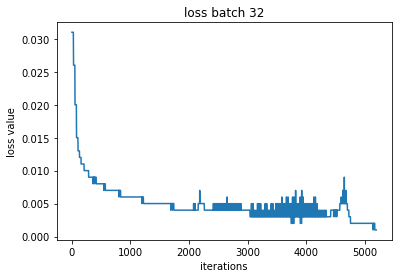

In [33]:
plt.plot(tt_acc_tracker.test_tracker.get_loss_graph())
plt.title('loss batch 32')
plt.xlabel('iterations')
plt.ylabel('loss value')

In [34]:
tt_acc_tracker.write_to_csv('/home/ron/PycharmProjects/Gait2019/plots/B32/')